### 필요한 라이브러리 다운

In [2]:
!pip install mplsoccer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Sbopen,Pitch, VerticalPitch, FontManager
pd.set_option('display.max_columns', 500)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.4/79.4 kB 1.4 MB/s eta 0:00:00


### 리그 데이터 받아오기

In [ ]:

parser = Sbopen()
## World Cup 2022
##df_match = parser.match(competition_id=43, season_id=106)

## Euro 2020
## df_match = parser.match(competition_id=55, season_id=43)

## Serie A 2015/16
df_match = parser.match(competition_id=12, season_id=27)
df_match.info()

3788741 ~ 3795506 UEFA Euro\n
3857254 ~ 3869685 FIFA World Cup
## Collecting Shots

In [4]:
df_matches = {}

for i, id in enumerate(df_match['match_id']):
    df_matches[id] = {}
    df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)

- Example

## Preparing Data

In [5]:
df_shot=pd.DataFrame(columns=['x', 'y', 'outcome_name', 'shot_statsbomb_xg'])

for id in df_match['match_id']:
  mask_shot = (df_matches[id]['event'].type_name=='Shot') & (df_matches[id]['event'].period<=4) &(df_matches[id]['event'].sub_type_name=='Open Play')
  shots_temp=df_matches[id]['event'].loc[mask_shot, ['x', 'y', 'outcome_name', 'shot_statsbomb_xg']]
  df_shot = pd.concat([df_shot, shots_temp]).reset_index(drop=True)

In [ ]:
df_shot

### visualizing shots

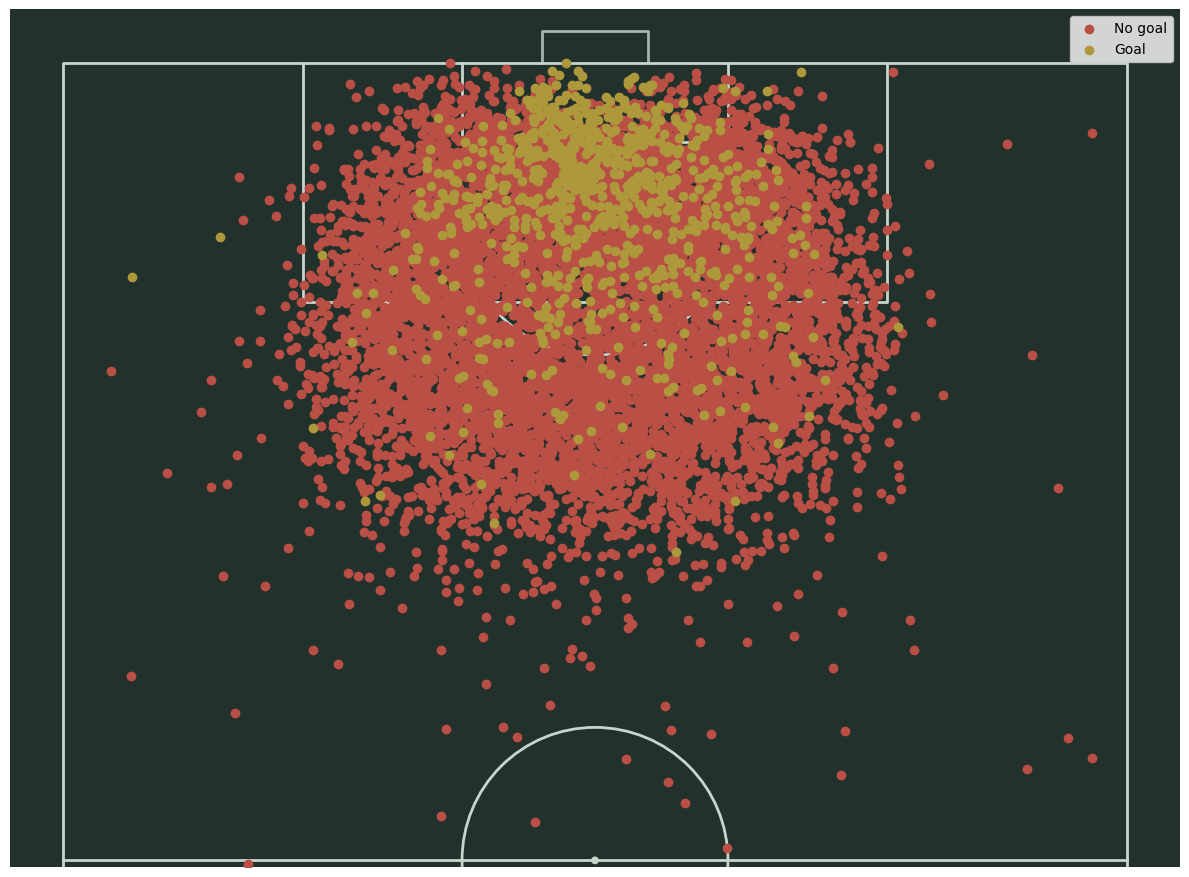

In [6]:
df_goals = df_shot[df_shot['outcome_name'] == 'Goal'].copy()
df_non_goal_shots = df_shot[df_shot['outcome_name'] != 'Goal'].copy()

# setup the pitch
pitch = VerticalPitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

sc1 = pitch.scatter(df_non_goal_shots.x, df_non_goal_shots.y,
                    c='#ba4f45',
                    marker='o',
                    ax=ax, label="No goal")

sc2 = pitch.scatter(df_goals.x, df_goals.y,
                    c='#ad993c',
                    marker='o',
                    ax=ax, label="Goal")

plt.legend(loc='best')
plt.show()

- 슈팅 좌표 기반으로 각도와 거리 계산하는 함수

In [7]:
import math
def calculate_angle(x, y):
  # 44 and 36 is the location of each goal post
  g0 = [120, 44]
  p = [x, y]
  g1 = [120, 36]

  v0 = np.array(g0) - np.array(p)
  v1 = np.array(g1) - np.array(p)

  angle = math.atan2(np.linalg.det([v0,v1]),np.dot(v0,v1))
  return(abs(np.degrees(angle)))

def calculate_distance(x, y):
  x_dist=120-x
  y_dist = abs(y - 40)  # y 거리는 y 좌표와 골대 중심 y 좌표(40)의 절대값 차이로 계산
  return math.sqrt(x_dist**2 + y_dist**2)


In [8]:
df_shot['angle']=df_shot.apply(lambda row:calculate_angle(row['x'], row['y']), axis=1)
df_shot['distance']=df_shot.apply(lambda row:calculate_distance(row['x'], row['y']), axis=1)
df_shot['goal']=df_shot.apply(lambda row : 1 if row['outcome_name']=='Goal' else 0, axis=1)

In [ ]:
df_shot.head()

In [ ]:
import altair as alt

fig = alt.Chart(df_shot).mark_point().encode(
  x='angle',y='goal')

fig + fig.transform_regression('angle','goal').mark_line()

In [ ]:
fig = alt.Chart(df_shot).mark_point().encode(
  x='distance',y='goal')

fig + fig.transform_regression('distance','goal').mark_line()

In [ ]:
df_shot['distance'].corr(df_shot['goal'])

In [ ]:
df_shot['angle'].corr(df_shot['goal'])

## Modeling
From the charts above, you can see the regression line between goal and the features, and it's confirmed that the wider the angle the more likely a shot become a goal, the closer the distance the more likely it become a goal

Now let's build our model using Linear Regression and also Logistic Regression, I'll explain why we can't use the Linear Regression model later

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.preprocessing import StandardScaler

model_names=['Linear', 'Logistic']
models={}
models['Linear']={}
models['Linear']['model']=LinearRegression()
models['Logistic']={}
models['Logistic']['model']=LogisticRegression()
# models['xGboost']={}
# models['xGboost']['model']=xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
#                            colsample_bytree=1, max_depth=7)

In [ ]:
X = df_shot[['angle', 'distance']]
y = df_shot['goal']
z=df_shot['shot_statsbomb_xg']

In [ ]:
X_standadized= StandardScaler().fit_transform(X)
X_standadized

In [ ]:
y

In [ ]:
z

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
X_standadized= StandardScaler().fit_transform(X)
X_standadized
# 데이터(X)만 넣었을 경우
X_train, X_test, y_train, y_test = train_test_split(X_standadized, y,test_size=0.3, random_state=123)


In [30]:
from sklearn import metrics
for mod in model_names:
  models[mod]['model'].fit(X_train,y_train)
  if mod=='Logistic':
    models[mod]['y_pred']=models[mod]['model'].predict_proba(X_test)[:,1]
    models[mod]['brier_score'] = metrics.brier_score_loss(y_test, models[mod]['y_pred'])
    print("Brier Score of model {}: {}".format(mod, models[mod]['brier_score']))
  else:
    models[mod]['y_pred'] = models[mod]['model'].predict(X_test)
    models[mod]['mse'] = metrics.mean_squared_error(y_test, models[mod]['y_pred'])
    print("MSE of model {}: {}".format(mod, models[mod]['mse']))

MSE of model Linear: 0.07096653545122453
Brier Score of model Logistic: 0.07027400579303998


In [ ]:
metrics.brier_score_loss(y, df_shot['shot_statsbomb_xg'])

In [ ]:
def calculate_xg(x,y):
  angle=calculate_angle(x,y)
  distance=calculate_distance(x,y)
  X=[[angle, distance]]
  # xg=models[mod]['model'].predict(X)
  xg=models[mod]['model'].predict_proba(X)[:,1][0]
  return xg

In [ ]:
df_evaluate = df_matches[3857262]['event'][df_matches[3857262]['event']['type_name'] == 'Shot'].copy()

In [ ]:
# take only open play
evaluate_mask = (df_evaluate.type_name == 'Shot') & (df_evaluate.period	<= 4) & (df_evaluate.sub_type_name	== 'Open Play')
df_evaluate = df_evaluate[evaluate_mask]

In [ ]:
df_evaluate['our_xg'] = df_evaluate.apply(lambda row:calculate_xg(row['x'], row['y']), axis=1)

In [ ]:
df_evaluate.team_name.unique()

In [ ]:
for team in df_evaluate.team_name.unique():
  df_team=df_evaluate[df_evaluate.team_name==team]
  actual_goal=len(df_team[df_team.outcome_name=='Goal'])
  sum_xg=df_team.our_xg.sum()
  sum_xg_sb=df_team.shot_statsbomb_xg.sum()

  print(team)
  print("Actual open play goal: " + str(actual_goal))
  print("Expected open play goal: " + str(round(sum_xg, 2)))
  print("Expected open play goal by Statsbomb: " + str(round(sum_xg_sb, 2)))


In [ ]:
df_matches[3857262]['event'].columns


# More Advanced xG Model with New Features
Features I can think of with the available Statsbomb data
- Shot types of play (penalty, free kick)
- Body part (header, preferable side)
- Is under pressure?
- Shot technique
- shot_first_time
- sequence of Play ->play_pattern_name               

### Making of advanced xG

In [ ]:
df_matches

In [9]:
# More Advanced xG Model with New Features
new_features=['x', 'y', 'outcome_name', 'sub_type_name', 'body_part_name','under_pressure', 'shot_first_time', 'technique_name', 'shot_statsbomb_xg','play_pattern_name']
df_shot = pd.DataFrame()
for id in df_match['match_id']:
  mask_shot=(df_matches[id]['event'].type_name=='Shot') & (df_matches[id]['event'].period<=4)
  shots_temp=df_matches[id]['event'].loc[mask_shot,new_features]
  df_shot=pd.concat([df_shot, shots_temp]).reset_index(drop=True)

In [ ]:
df_shot

In [10]:
df_shot['angle']=df_shot.apply(lambda row:calculate_angle(row['x'], row['y']), axis=1)
df_shot['distance']=df_shot.apply(lambda row:calculate_distance(row['x'], row['y']), axis=1)

df_shot['under_pressure']=df_shot['under_pressure'].fillna(0)
df_shot['under_pressure']=df_shot['under_pressure'].astype(int)

df_shot['shot_first_time']=df_shot['shot_first_time'].fillna(0)
df_shot['shot_first_time']=df_shot['shot_first_time'].astype(int)

df_shot=pd.get_dummies(df_shot,columns=['body_part_name'])
df_shot=pd.get_dummies(df_shot,columns=['technique_name'])
df_shot=pd.get_dummies(df_shot, columns=['sub_type_name'])
df_shot=pd.get_dummies(df_shot, columns=['play_pattern_name'])
df_shot['goal']=df_shot.apply(lambda row:1 if row['outcome_name']=='Goal' else 0, axis=1)

In [11]:
df_shot['body_part_name_Foot'] = df_shot['body_part_name_Left Foot'] + df_shot['body_part_name_Right Foot']

# 불필요한 열 제거: 'Left Foot', 'Right Foot' 열 제거
df_shot.drop(['body_part_name_Left Foot', 'body_part_name_Right Foot', 'body_part_name_Other'], axis=1, inplace=True)


In [12]:
X_cols = ['angle', 'distance','under_pressure', 'shot_first_time', 'body_part_name_Foot','body_part_name_Head',
          'technique_name_Backheel','technique_name_Diving Header', 'technique_name_Half Volley',
          'technique_name_Lob', 'technique_name_Normal','technique_name_Overhead Kick', 'technique_name_Volley',
          'sub_type_name_Corner', 'sub_type_name_Free Kick','sub_type_name_Open Play', 'sub_type_name_Penalty',
          'play_pattern_name_From Counter', 'play_pattern_name_From Free Kick','play_pattern_name_From Goal Kick',
          'play_pattern_name_From Keeper', 'play_pattern_name_From Kick Off', 'play_pattern_name_From Throw In',
          'play_pattern_name_Other', 'play_pattern_name_Regular Play']

X = df_shot[X_cols]
y = df_shot['goal']

In [13]:
X

,angle,distance,under_pressure,shot_first_time,body_part_name_Foot,body_part_name_Head,technique_name_Backheel,technique_name_Diving Header,technique_name_Half Volley,technique_name_Lob,technique_name_Normal,technique_name_Overhead Kick,technique_name_Volley,sub_type_name_Corner,sub_type_name_Free Kick,sub_type_name_Open Play,sub_type_name_Penalty,play_pattern_name_From Counter,play_pattern_name_From Free Kick,play_pattern_name_From Goal Kick,play_pattern_name_From Keeper,play_pattern_name_From Kick Off,play_pattern_name_From Throw In,play_pattern_name_Other,play_pattern_name_Regular Play
0,43.906819,9.082401,1,0,False,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False
1,11.089952,31.487458,0,0,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True
2,44.296281,9.773945,1,0,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False
3,37.156345,11.900420,0,0,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,True,False
4,12.257634,19.126160,0,1,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,21.167658,21.403738,1,0,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True
9994,18.747958,20.412986,0,1,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False
9995,18.999331,19.809089,0,1,True,False,False,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False
9996,43.480463,10.017984,0,0,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False


In [14]:
y

0       1
1       0
2       0
3       1
4       0
       ..
9993    0
9994    0
9995    0
9996    0
9997    0
Name: goal, Length: 9998, dtype: int64

In [17]:
import numpy as np
from sklearn.model_selection import train_test_split
feature_to_scale=X[['angle','distance']]
scaler = StandardScaler()
scaled_feature= scaler.fit_transform(feature_to_scale)
mean = scaler.mean_
std = scaler.scale_
scaled_feature_df=pd.DataFrame(scaled_feature, columns=['angle','distance'])
X_scaled=X.copy()
X_scaled.update(scaled_feature_df)

In [18]:
mean, std

(array([23.86943849, 20.3750036 ]), array([14.63773157,  8.81828594]))

### 트레인 테스트 분할

In [31]:
import joblib
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=118)

adv_model = LogisticRegression()
adv_model.fit(X_train, y_train)
y_pred = adv_model.predict_proba(X_test)[:, 1]
metrics.brier_score_loss(y_test, y_pred)
joblib.dump(adv_model, '/content/adv_model.joblib')

['/content/adv_model.joblib']

### 상관계수 분석

In [ ]:
df_shot.loc[X_test.index, 'xG_adv'] = y_pred

corr_cols  = ['under_pressure', 'shot_first_time', 'angle', 'distance','body_part_name_Foot','body_part_name_Head',
          'technique_name_Backheel','technique_name_Diving Header', 'technique_name_Half Volley',
          'technique_name_Lob', 'technique_name_Normal','technique_name_Overhead Kick', 'technique_name_Volley',
          'sub_type_name_Corner', 'sub_type_name_Free Kick','sub_type_name_Open Play', 'sub_type_name_Penalty',
          'play_pattern_name_From Counter', 'play_pattern_name_From Free Kick','play_pattern_name_From Goal Kick',
          'play_pattern_name_From Keeper', 'play_pattern_name_From Kick Off', 'play_pattern_name_From Throw In',
          'play_pattern_name_Other', 'play_pattern_name_Regular Play',
          'xG_adv']

df_shot[corr_cols].corr().iloc[:,-1].sort_values()

In [ ]:
from sklearn import metrics
brier_score = metrics.brier_score_loss(y_test, y_pred)

# Brier Score 출력
print("Brier Score of model: {}".format(brier_score))


In [ ]:
df_matches

## 일반화(함수 제작)

In [32]:
def calculate_xg_adv(row):
  # print(type(row['shot_first_time']))
  # print(type(row['under_pressure']))

  shot_first_time = 0 if np.isnan(row['shot_first_time']) or row['shot_first_time'] is False else 1
  under_pressure = 0 if np.isnan(row['under_pressure']) or row['under_pressure'] is False else 1

  angle = calculate_angle(row['x'], row['y'])
  distance = calculate_distance(row['x'], row['y'])

  scaled_angle = (angle - mean[0]) / std[0]
  scaled_distance = (distance - mean[1]) / std[1]


  body_part_name = {'Foot': 0, 'Head': 0}
  play_pattern_name = {'From Counter': 0, 'From Free Kick': 0,
                         'From Goal Kick': 0, 'From Keeper': 0,
                         'From Kick Off': 0, 'From Throw In': 0,
                         'From Other': 0, 'From Regular Play': 0}
  technique_name = {'Backheel': 0, 'Diving Header': 0,
                      'Half Volley': 0, 'Lob': 0,
                      'Normal': 0, 'Overhead Kick': 0,
                      'Volley': 0}
  sub_type_name = {'Corner': 0, 'Free Kick': 0,
                     'Open Play': 0, 'Penalty': 0}

  body_part_name['Head'] = 1 if row['body_part_name'] == 'Head' else 0
  body_part_name['Foot'] = 1 if row['body_part_name'] in ['Left Foot', 'Right Foot'] else 0

  if row['play_pattern_name'] in play_pattern_name:
        play_pattern_name[row['play_pattern_name']] = 1
  if row['technique_name'] in technique_name:
        technique_name[row['technique_name']] = 1
  if row['sub_type_name'] in sub_type_name:
        sub_type_name[row['sub_type_name']] = 1




  X = [[scaled_angle, scaled_distance, under_pressure,  shot_first_time,

        body_part_name['Foot'], body_part_name['Head'],

        technique_name['Backheel'], technique_name['Diving Header'],
        technique_name['Half Volley'], technique_name['Lob'],
        technique_name['Normal'], technique_name['Overhead Kick'],technique_name['Volley'],

        sub_type_name['Corner'],sub_type_name['Free Kick'], sub_type_name['Open Play'],sub_type_name['Penalty'],

        play_pattern_name['From Counter'], play_pattern_name['From Free Kick'],
        play_pattern_name['From Goal Kick'], play_pattern_name['From Keeper'],
        play_pattern_name['From Kick Off'], play_pattern_name['From Throw In'],
        play_pattern_name['From Other'], play_pattern_name['From Regular Play']]]


  xg = adv_model.predict_proba(X)[:, 1][0]
  return xg

- Example

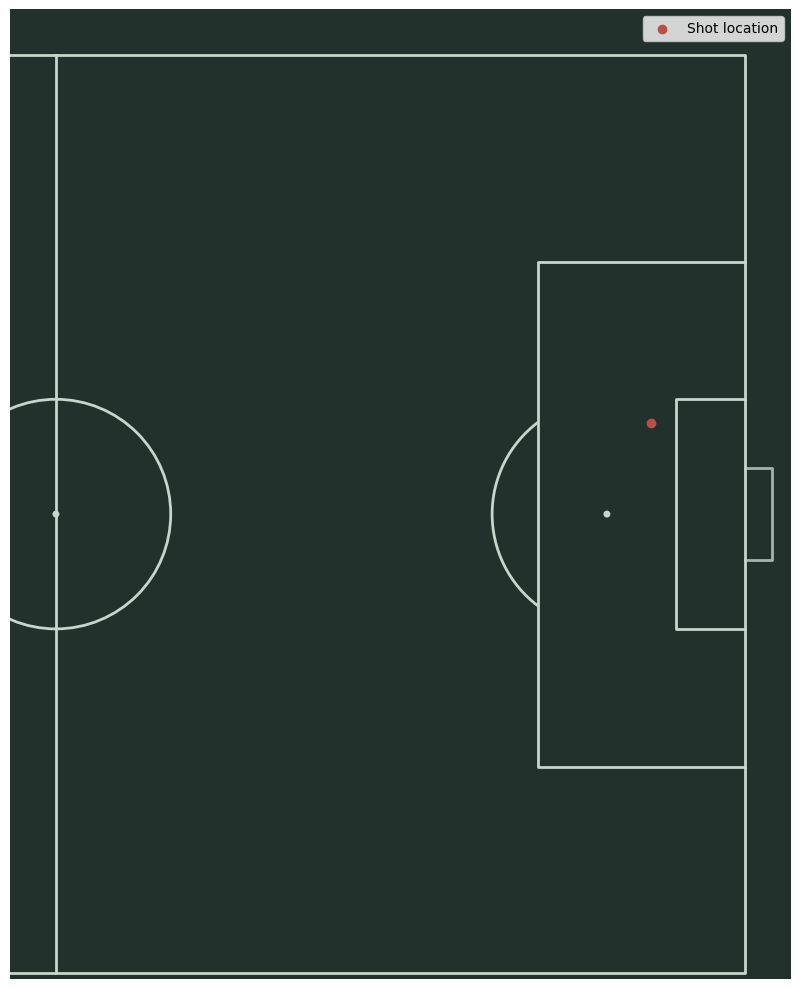

Predicted xG: 0.3034537510509696


In [34]:
from mplsoccer import Pitch
row = {
        'under_pressure': False,
        'shot_first_time': True,
        'x': 111.8,
        'y': 32.1,
        'body_part_name': 'Left Foot',
        'technique_name': 'Normal',
        'sub_type_name': 'Open Play',
        'play_pattern_name': 'From Counter'
}


# setup the pitch
pitch =Pitch(pad_bottom=0.5,  # pitch extends slightly below halfway line
                      half=True,  # half of a pitch
                      goal_type='box',
                      goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')  # control the goal transparency

fig, ax = pitch.draw(figsize=(12, 10))

sc1 = pitch.scatter(row['x'], row['y'],
                    c='#ba4f45',
                    marker='o',
                    ax=ax, label="Shot location")


plt.legend(loc='best')
plt.show()
# 함수 호출 및 출력
xg = calculate_xg_adv(row)
print("Predicted xG:", xg)

## 여러 명의 위치에 따른 xG 구현

In [19]:
from mplsoccer import Pitch
import numpy as np
def draw_grid_on_pitch(actor_coor, team_coor, oppo_coor):
# setup the full pitch
  pitch = Pitch(pitch_type='statsbomb', pad_bottom=1, label=True, axis=True,
                half=False,  # full pitch
                pitch_length=105, pitch_width=68,  # using 105x68 dimensions
                goal_type='box',
                goal_alpha=0.8, pitch_color='#22312b', line_color='#c7d5cc')

  fig, ax = pitch.draw(figsize=(12, 7))

  # 축구장을 수평으로 나누기
  h_lines = np.linspace(0, 80, 21)  # 축구장의 y-좌표를 17개 구역으로 나눔
  for y in h_lines:
      ax.axhline(y, color='white', linestyle='-',linewidth=0.5)  # 수평선 추가

  # 축구장을 수직으로 나누기
  v_lines = np.linspace(0, 120, 31)  # 축구장의 x-좌표를 27개 구역으로 나눔
  for x in v_lines:
      ax.axvline(x, color='white', linestyle='-', linewidth=0.5)  # 수직선 추가


  actor = pitch.scatter(*zip(*actor_coor), c='#ba4f45', marker='o', ax=ax, s=70, edgecolors='white', linewidths=0.5)
  teammates = pitch.scatter(*zip(*team_coor), c='#f4cccc', marker='o', ax=ax, s=70, edgecolors='white', linewidths=0.5)
  oppopnents = pitch.scatter(*zip(*oppo_coor), c='#3d85c6', marker='o', ax=ax, s=70, edgecolors='white', linewidths=0.5)

  all_players = actor_coor + team_coor
  for coor in all_players:
    #print(coor)
    row = {
          'under_pressure': False,
          'shot_first_time': True,
          'x': coor[0],
          'y': coor[1],
          'body_part_name': 'Left Foot',
          'technique_name': 'Normal',
          'sub_type_name': 'Open Play',
          'play_pattern_name': 'From Counter'
  }
    xg = calculate_xg_adv(row)
    ax.text(coor[0], coor[1] + 0, f"{xg:.2f}", color='white', ha='center', va='bottom', fontsize=12, zorder=2)

  ax.tick_params(colors='black', which='both')  # 모든 눈금의 색상을 노란색으로 변경


  # 레전드 핸들러 생성
  from matplotlib.lines import Line2D
  legend_elements = [Line2D([0], [0], marker='o', color='w', label='actor', markerfacecolor='#ba4f45', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='teammates', markerfacecolor='#f4cccc', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='opponents', markerfacecolor='#3d85c6', markersize=10)]


  # 레전드 추가
  ax.legend(handles=legend_elements, loc='upper left')  # 상단 왼쪽으로 레전드 위치 조정
  plt.show()



In [ ]:
new_features = ['team_name','shot_first_time','outcome_name','play_pattern_name', 'x', 'y', 'sub_type_name', 'body_part_name', 'under_pressure', 'technique_name', 'shot_statsbomb_xg']
df_shot_team = pd.DataFrame(columns=new_features)

for id in df_match['match_id']:
  mask_shot = (df_matches[id]['event'].type_name == 'Shot') & (df_matches[id]['event'].period <= 4)
  shots_temp = df_matches[id]['event'].loc[mask_shot, new_features]
  df_shot_team = pd.concat([df_shot_team, shots_temp]).reset_index(drop=True)

df_shot_team['our_xg'] = df_shot_team.apply(lambda row:calculate_xg_adv(row), axis=1)
df_shot_team['goal'] = df_shot_team.apply(lambda row:1 if row['outcome_name'] == 'Goal' else 0, axis=1)
team_summary = df_shot_team.groupby('team_name')[['our_xg', 'shot_statsbomb_xg', 'goal']].sum().reset_index()

In [ ]:
team_summary

In [ ]:
team_summary[['our_xg',	'shot_statsbomb_xg']].mean()


### actor, teammates, opponents 위치 구현하기

In [21]:
## World Cup 2022
df_match = parser.match(competition_id=43, season_id=106)

df_matches = {}
for i, id in enumerate(df_match['match_id']):
    df_matches[id] = {}
    df_matches[id]['event'], df_matches[id]['related'], df_matches[id]['freeze'], df_matches[id]['tactic'] = parser.event(id)

In [22]:
df_frame, df_visible = parser.frame(3869685)
#first game of WC 2022

# exploring the data
df_frame.info()
df_visible.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61451 entries, 0 to 61450
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   teammate  61451 non-null  bool   
 1   actor     61451 non-null  bool   
 2   keeper    61451 non-null  bool   
 3   match_id  61451 non-null  int64  
 4   id        61451 non-null  object 
 5   x         61451 non-null  float64
 6   y         61451 non-null  float64
dtypes: bool(3), float64(2), int64(1), object(1)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   match_id      3683 non-null   int64 
 1   id            3683 non-null   object
 2   visible_area  3683 non-null   object
dtypes: int64(1), object(2)
memory usage: 86.4+ KB


In [ ]:
df_matches[3869685]['event'].iloc[137:178,:]

In [ ]:
test_dataframe=df_matches[3869685]['event']
test_dataframe[test_dataframe['type_name']=='Shot'][['id', 'x','y','timestamp', 'type_name','player_name','pass_length', 'shot_statsbomb_xg']]

In [ ]:
df_matches[3869685]['event'].iloc[1153:1180,:][['id', 'x','y','timestamp', 'type_name','player_name','pass_length', 'shot_statsbomb_xg','body_part_name','sub_type_name','outcome_name','pass_height_name','shot_statsbomb_xg']]

In [ ]:
test_row=df_matches[3869685]['event'].iloc[4069:4069+1,:].iloc[0]
test_row
xg_value = calculate_xg_adv(test_row)
xg_value

In [36]:
def draw_position(sequence_id):
  sequence=df_frame[df_frame['id']==sequence_id]

  actor=sequence[sequence['actor']==True]
  actor_position = [(actor['x'].iloc[0], actor['y'].iloc[0])]

  teammate = sequence[(sequence['teammate'] == True) & (sequence['actor'] == False)]
  teammate_position=[(teammate['x'].iloc[i], teammate['y'].iloc[i]) for i in range(len(teammate))]

  opponent=sequence[sequence['teammate']==False]
  opponent_position=[(opponent['x'].iloc[i], opponent['y'].iloc[i]) for i in range(len(opponent))]

  return draw_grid_on_pitch(actor_position, teammate_position, opponent_position)



In [ ]:
sequence=df_frame[df_frame['id']=='ed70825d-8a40-470d-8b30-fd315ab5f0a6']
sequence

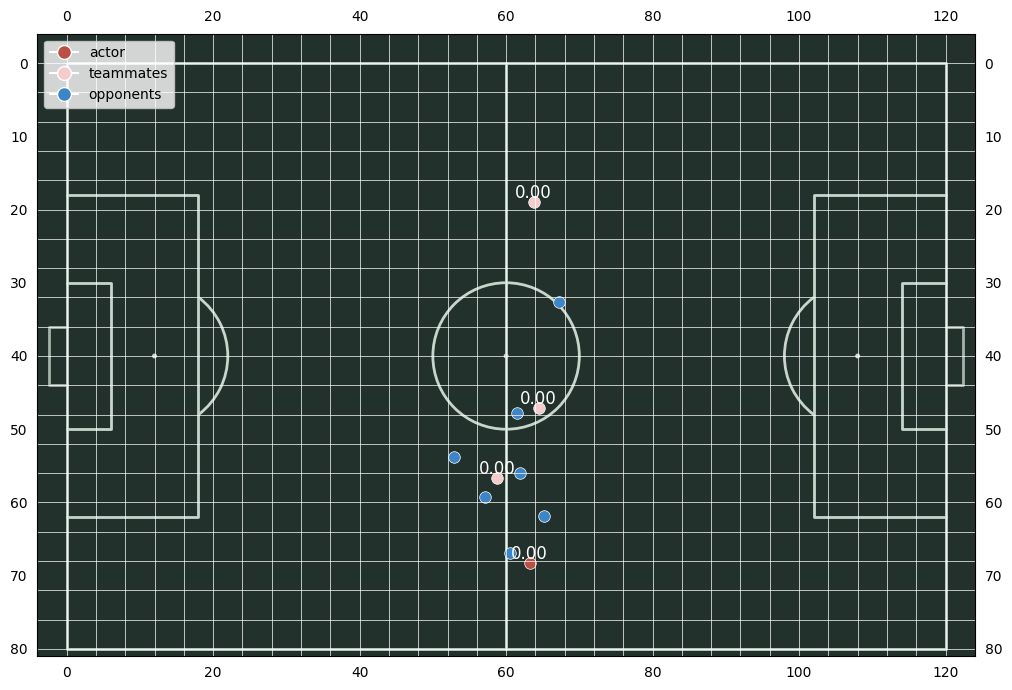

In [37]:
draw_position('5a800227-911a-4490-b828-14ece1f81d76')

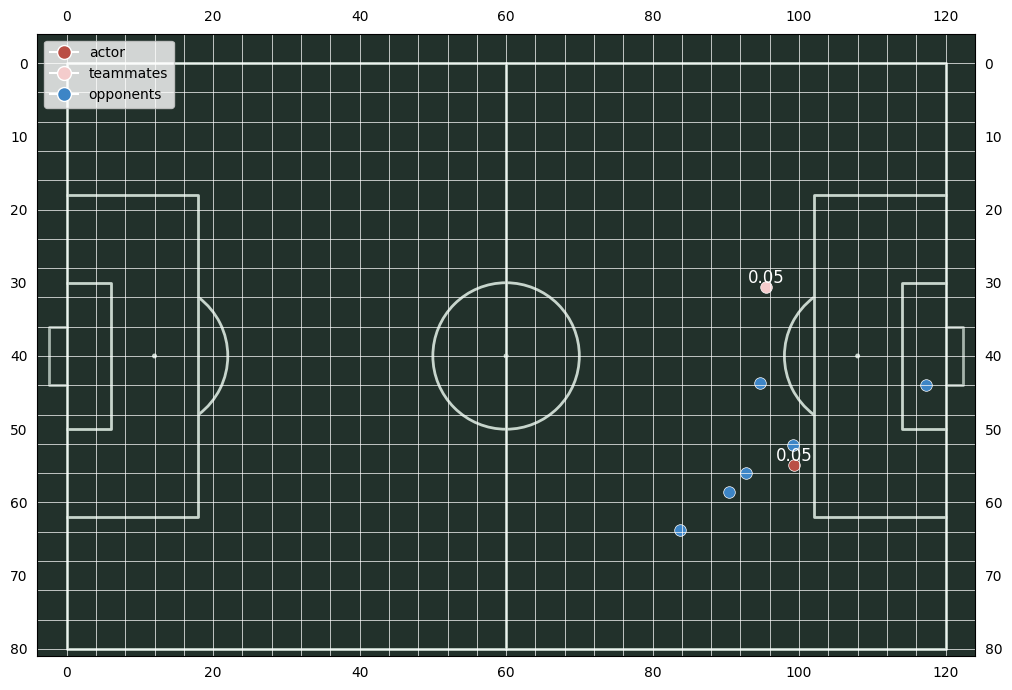

In [38]:
draw_position('ed70825d-8a40-470d-8b30-fd315ab5f0a6')

In [ ]:
draw_position('ef86f4d9-7acd-4ed0-a5ec-9129079e8fbe')

In [ ]:
prac_position=df_frame[df_frame['id']=="ef86f4d9-7acd-4ed0-a5ec-9129079e8fbe"]
prac_position

In [27]:
def calculate_xag(row):


  sequence=df_frame[df_frame['id']==row['id']]
  teammate = sequence[(sequence['teammate'] == True) & (sequence['actor'] == False)]
  teammate_position=[(teammate['x'].iloc[i], teammate['y'].iloc[i]) for i in range(len(teammate))]

  xag_product =1.0
  for position in teammate_position:
    modified_row = row.copy()
    modified_row['x'], modified_row['y'] = position

    # 각 팀메이트의 위치에서 xG 계산
    xg_value = calculate_xg_adv(modified_row)

    # 득점하지 못할 확률을 누적 곱함
    xag_product *= (1 - xg_value)

    # 최종 xAG 값 계산
  xag_result = 1 - xag_product
  return xag_result





In [33]:
row=df_matches[3869685]['event'].iloc[1177:1178,:].iloc[0]
print(calculate_xag(row))
print(calculate_xg_adv(row))


0.14088556382457296
0.3034537510509696


In [ ]:
df_matches[3869685]['event'].iloc[1177:1178,:]

In [ ]:
df_evaluate = df_matches[3869685]['event'].copy()  # .copy()를 사용하여 명확하게 복사본을 만들어 작업
evaluate_mask = (df_evaluate['type_name'].isin(['Clearance', 'Pass', 'Shot', 'Carry'])) & (df_evaluate['period'] <= 4)
df_evaluate = df_evaluate[evaluate_mask]

df_evaluate['xg'] = df_evaluate.apply(lambda row: calculate_xg_adv(row), axis=1)

df_summary=df_evaluate[['id','timestamp','possession_team_name','type_name','x','y','end_x','end_y','pass_height_name','xg', 'outcome_name']].copy()
df_summary['xg'] = df_summary['xg'].round(4)


In [39]:
df_summary

NameError: name 'df_summary' is not defined

In [ ]:
!pip install mplsoccer